In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys

In [3]:
base_path = pathlib.Path(os.getcwd())
base_path = str(base_path.parent)
sys.path = [base_path] + sys.path

In [4]:
import glob
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [6]:
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1.0, color_codes=True)

In [7]:
os.makedirs("./img/", exist_ok=True)
os.makedirs("./score/", exist_ok=True)

In [8]:
def set_experimental_environment(seed=6902):
    K.clear_session()

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.
    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    python_random.seed(seed)

    # The below set_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see:
    # https://www.tensorflow.org/api_docs/python/tf/random/set_seed
    tf.random.set_seed(seed)

In [9]:
from pynvml import *

try:
    nvmlInit()
    print("Driver Version:", nvmlSystemGetDriverVersion())
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
    nvmlShutdown()
except NVMLError as error:
    print(error)

Driver Version: b'419.17'
Device 0 : b'GeForce GTX 1070 Ti'


In [10]:
from cpuinfo import get_cpu_info

for key, value in get_cpu_info().items():
    print("{0}: {1}".format(key, value))

python_version: 3.6.10.final.0 (64 bit)
cpuinfo_version: [7, 0, 0]
cpuinfo_version_string: 7.0.0
arch: X86_64
bits: 64
count: 12
arch_string_raw: AMD64
vendor_id_raw: GenuineIntel
brand_raw: Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
hz_advertised_friendly: 3.2000 GHz
hz_actual_friendly: 3.1920 GHz
hz_advertised: [3200000000, 0]
hz_actual: [3192000000, 0]
l2_cache_size: 1572864
stepping: 10
model: 158
family: 6
l3_cache_size: 12582912
flags: ['3dnow', '3dnowprefetch', 'abm', 'acpi', 'adx', 'aes', 'apic', 'avx', 'avx2', 'bmi1', 'bmi2', 'clflush', 'clflushopt', 'cmov', 'cx16', 'cx8', 'de', 'dtes64', 'dts', 'erms', 'est', 'f16c', 'fma', 'fpu', 'fxsr', 'hle', 'ht', 'hypervisor', 'ia64', 'invpcid', 'lahf_lm', 'mca', 'mce', 'mmx', 'movbe', 'mpx', 'msr', 'mtrr', 'osxsave', 'pae', 'pat', 'pbe', 'pcid', 'pclmulqdq', 'pdcm', 'pge', 'pni', 'popcnt', 'pse', 'pse36', 'rdrnd', 'rdseed', 'rtm', 'sep', 'serial', 'smap', 'smep', 'ss', 'sse', 'sse2', 'sse4_1', 'sse4_2', 'ssse3', 'tm', 'tm2', 'tsc', 'vme', 

In [11]:
import psutil 

mem = psutil.virtual_memory() 
print("memory: {0:.2f}GB".format(mem.total / 1024**3))

memory: 15.92GB


In [12]:
BAYES_MODELS = [
    "MNIST-CNN",
]

LAST_ACTIVATIONS = [
    "softmax",
    "sigmoid",
]

PREDICTION_MODES = [
    "Normal-mode",
    "Linear-mode",
    "Independent-mode",
    "Upper-mode",
    "MC-mode",
]

DATASETS = [
    "MNIST",
    "Fashion",
    "Kuzushiji",
    "Kannada",
    "EMNIST-MNIST",
]

In [13]:
class Args(object):
    max_seed = 30
    train_domain = DATASETS[1]
    bayes_model= BAYES_MODELS[0]
    num_mc = 100
    optimizer = "Adam"
    train_batch_size = 128
    test_batch_size = 2048
    max_epochs = 100
    patience = 10
    rho = 0.01

In [14]:
def kuzushiji_load_data():
    ds = tfds.load(
        "kmnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    return (x_train, y_train), (x_test, y_test)


def kannada_load_data():
    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_train.npz",
    )
    y_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_train.npz",
    )
    x_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_test.npz",
    )
    y_test = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_test.npz",
    )
    x_test = np.load(path)["arr_0"]

    return (x_train, y_train), (x_test, y_test)


def emnist_mnist_load_data():
    ds = tfds.load(
        "emnist/mnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    x_train = np.array([x.T for x in x_train])
    x_test = np.array([x.T for x in x_test])

    return (x_train, y_train), (x_test, y_test)


def load_dataset(dataset, val_size=1.0 / 6.0):
    if dataset == DATASETS[0]:
        load_data = keras.datasets.mnist.load_data
    elif dataset == DATASETS[1]:
        load_data = keras.datasets.fashion_mnist.load_data
    elif dataset == DATASETS[2]:
        load_data = kuzushiji_load_data
    elif dataset == DATASETS[3]:
        load_data = kannada_load_data
    elif dataset == DATASETS[4]:
        load_data = emnist_mnist_load_data
    else:
        raise ValueError("Error")

    # input image dimensions
    num_classes = 10

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    if val_size > 0.0:
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=val_size, stratify=y_train
        )
    else:
        x_val, y_val = x_train, y_train

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), num_classes

In [15]:
def calc_softmax_entropy(prob):
    entropy = np.sum(-prob * np.log(np.maximum(prob, 1.0e-5)), axis=-1)
    return entropy


def calc_sigmoid_entropy(prob):
    entropy = np.sum(
        -prob * np.log(np.maximum(prob, 1.0e-5))
        - (1.0 - prob) * np.log(np.maximum(1.0 - prob, 1.0e-5)),
        axis=-1,
    )
    return entropy

In [16]:
def create_last_bayes_model(input_shape, output_shape, last_activation):
    # https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    inputs = keras.Input(input_shape)
    conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
    conv2 = layers.Conv2D(64, (3, 3), activation="relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop1 = layers.Dropout(0.25)(pool1)
    flat1 = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation="relu")(flat1)
    drop2 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(output_shape, activation=last_activation)(drop2)
    model = keras.Model(inputs=inputs, outputs=dense2)

    return model


def create_bayes_model(bayes_model_name, input_shape, output_shape, last_activation):
    if bayes_model_name == BAYES_MODELS[0]:
        model = create_last_bayes_model(input_shape, output_shape, last_activation)
    else:
        raise ValueError()

    return model

In [17]:
args = Args()

In [18]:
from vpbnn import vlayers
from vpbnn.models import nn2vpbnn

for seed in range(args.max_seed):
    for last_activation in LAST_ACTIVATIONS:
        set_experimental_environment(seed)
        
        (x_train, y_train), (x_val, y_val), (_, _), num_classes = load_dataset(
            args.train_domain
        )        
        
        input_shape = x_train.shape[1:]
        model = create_bayes_model(
            args.bayes_model, input_shape, num_classes, last_activation
        )

        if last_activation == LAST_ACTIVATIONS[0]:
            loss_func = "categorical_crossentropy"
            calc_entropy = calc_softmax_entropy
        elif last_activation == LAST_ACTIVATIONS[1]:
            loss_func = "binary_crossentropy"
            calc_entropy = calc_sigmoid_entropy
        else:
            raise ValueError()

        es = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=args.patience,
            verbose=1,
            mode="auto",
            restore_best_weights=True,
        )

        model.compile(
            loss=loss_func, optimizer=args.optimizer, metrics=["accuracy"],
        )

        model.fit(
            x_train,
            y_train,
            batch_size=args.train_batch_size,
            epochs=args.max_epochs,
            verbose=2,
            validation_data=(x_val, y_val),
            callbacks=[es],
        )
        
        vmodel = nn2vpbnn(model, rho=args.rho)
        
        score_dfs = []
        for prediction_type in PREDICTION_MODES:
            for test_domain in DATASETS:
                (_, _), (_, _), (x_test, y_test), _ = load_dataset(test_domain)
                if prediction_type == PREDICTION_MODES[0]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 0
                    vmodel.compile(loss=loss_func)

                    y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[1]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 1
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[2]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 2
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[3]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 3
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)            
                elif prediction_type == PREDICTION_MODES[4]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 4
                    vmodel.compile(loss=loss_func)

                    y_probs = []
                    for _ in range(args.num_mc):
                        for layer in model.layers:
                            if isinstance(layer, vlayers.VarianceDropout):
                                layer.update_dropout_mask()
                        y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
                        y_probs.append(y_prob)
                    y_probs = np.array(y_probs)
                    y_prob = y_probs.mean(axis=0)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(y_probs.std(axis=0, ddof=1), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                else:
                    raise ValueError()
        score_df = pd.concat(score_dfs, ignore_index=True)
        score_df["seed"] = seed
        score_df["bayes_model"] = args.bayes_model
        score_df["last_activation"] = last_activation    
        score_df.to_csv("score/ood_{0}_{1:03}.csv".format(last_activation, seed), index=False)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 5s - loss: 0.5429 - accuracy: 0.8079 - val_loss: 0.3195 - val_accuracy: 0.8825
Epoch 2/100
50000/50000 - 3s - loss: 0.3502 - accuracy: 0.8758 - val_loss: 0.2736 - val_accuracy: 0.8991
Epoch 3/100
50000/50000 - 3s - loss: 0.3030 - accuracy: 0.8912 - val_loss: 0.2519 - val_accuracy: 0.9067
Epoch 4/100
50000/50000 - 3s - loss: 0.2699 - accuracy: 0.9027 - val_loss: 0.2305 - val_accuracy: 0.9149
Epoch 5/100
50000/50000 - 3s - loss: 0.2469 - accuracy: 0.9094 - val_loss: 0.2200 - val_accuracy: 0.9181
Epoch 6/100
50000/50000 - 3s - loss: 0.2246 - accuracy: 0.9171 - val_loss: 0.2199 - val_accuracy: 0.9201
Epoch 7/100
50000/50000 - 3s - loss: 0.2088 - accuracy: 0.9232 - val_loss: 0.2115 - val_accuracy: 0.9230
Epoch 8/100
50000/50000 - 3s - loss: 0.1914 - accuracy: 0.9284 - val_loss: 0.2064 - val_accuracy: 0.9263
Epoch 9/100
50000/50000 - 3s - loss: 0.1775 - accuracy: 0.9340 - val_loss: 0.1993 - val_accuracy: 0.9289
Epoch

Epoch 13/100
50000/50000 - 3s - loss: 0.0329 - accuracy: 0.9871 - val_loss: 0.0386 - val_accuracy: 0.9855
Epoch 14/100
50000/50000 - 3s - loss: 0.0316 - accuracy: 0.9873 - val_loss: 0.0388 - val_accuracy: 0.9853
Epoch 15/100
50000/50000 - 3s - loss: 0.0304 - accuracy: 0.9881 - val_loss: 0.0391 - val_accuracy: 0.9856
Epoch 16/100
50000/50000 - 3s - loss: 0.0293 - accuracy: 0.9884 - val_loss: 0.0391 - val_accuracy: 0.9860
Epoch 17/100
50000/50000 - 3s - loss: 0.0283 - accuracy: 0.9888 - val_loss: 0.0397 - val_accuracy: 0.9857
Epoch 18/100
50000/50000 - 3s - loss: 0.0273 - accuracy: 0.9893 - val_loss: 0.0412 - val_accuracy: 0.9853
Epoch 19/100
50000/50000 - 3s - loss: 0.0266 - accuracy: 0.9893 - val_loss: 0.0410 - val_accuracy: 0.9855
Epoch 20/100
50000/50000 - 3s - loss: 0.0255 - accuracy: 0.9898 - val_loss: 0.0389 - val_accuracy: 0.9858
Epoch 21/100
50000/50000 - 3s - loss: 0.0248 - accuracy: 0.9900 - val_loss: 0.0410 - val_accuracy: 0.9857
Epoch 22/100
Restoring model weights from the 

Epoch 17/100
50000/50000 - 3s - loss: 0.1205 - accuracy: 0.9540 - val_loss: 0.2109 - val_accuracy: 0.9299
Epoch 18/100
50000/50000 - 3s - loss: 0.1164 - accuracy: 0.9549 - val_loss: 0.2203 - val_accuracy: 0.9296
Epoch 19/100
50000/50000 - 3s - loss: 0.1101 - accuracy: 0.9570 - val_loss: 0.2277 - val_accuracy: 0.9280
Epoch 20/100
50000/50000 - 3s - loss: 0.1000 - accuracy: 0.9621 - val_loss: 0.2468 - val_accuracy: 0.9290
Epoch 21/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.1023 - accuracy: 0.9616 - val_loss: 0.2282 - val_accuracy: 0.9320
Epoch 00021: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1187 - accuracy: 0.9547 - val_loss: 0.0648 - val_accuracy: 0.9752
Epoch 2/100
50000/50000 - 3s - loss: 0.0718 - accuracy: 0.9725 - val_loss: 0.0554 - val_accuracy: 0.9785
Epoch 3/100
50000/50000 - 3s - loss: 0.0615 - accuracy: 0.9762 - val_loss: 0.0492 - val_accuracy: 0.9810
Epoch 4/100
50000/500

Epoch 00021: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5358 - accuracy: 0.8112 - val_loss: 0.3375 - val_accuracy: 0.8777
Epoch 2/100
50000/50000 - 3s - loss: 0.3438 - accuracy: 0.8758 - val_loss: 0.2909 - val_accuracy: 0.8986
Epoch 3/100
50000/50000 - 3s - loss: 0.2973 - accuracy: 0.8932 - val_loss: 0.2755 - val_accuracy: 0.9024
Epoch 4/100
50000/50000 - 3s - loss: 0.2654 - accuracy: 0.9024 - val_loss: 0.2578 - val_accuracy: 0.9050
Epoch 5/100
50000/50000 - 3s - loss: 0.2378 - accuracy: 0.9121 - val_loss: 0.2418 - val_accuracy: 0.9124
Epoch 6/100
50000/50000 - 3s - loss: 0.2225 - accuracy: 0.9173 - val_loss: 0.2352 - val_accuracy: 0.9150
Epoch 7/100
50000/50000 - 3s - loss: 0.2028 - accuracy: 0.9245 - val_loss: 0.2212 - val_accuracy: 0.9191
Epoch 8/100
50000/50000 - 3s - loss: 0.1880 - accuracy: 0.9299 - val_loss: 0.2294 - val_accuracy: 0.9176
Epoch 9/100
50000/50000 - 3s - loss: 0.1759 - accuracy: 0.9345 - val_loss: 0.2161 

50000/50000 - 3s - loss: 0.0452 - accuracy: 0.9822 - val_loss: 0.0440 - val_accuracy: 0.9827
Epoch 8/100
50000/50000 - 3s - loss: 0.0430 - accuracy: 0.9834 - val_loss: 0.0432 - val_accuracy: 0.9831
Epoch 9/100
50000/50000 - 3s - loss: 0.0406 - accuracy: 0.9844 - val_loss: 0.0421 - val_accuracy: 0.9835
Epoch 10/100
50000/50000 - 3s - loss: 0.0391 - accuracy: 0.9846 - val_loss: 0.0413 - val_accuracy: 0.9843
Epoch 11/100
50000/50000 - 3s - loss: 0.0364 - accuracy: 0.9856 - val_loss: 0.0410 - val_accuracy: 0.9844
Epoch 12/100
50000/50000 - 3s - loss: 0.0355 - accuracy: 0.9858 - val_loss: 0.0401 - val_accuracy: 0.9850
Epoch 13/100
50000/50000 - 3s - loss: 0.0341 - accuracy: 0.9865 - val_loss: 0.0406 - val_accuracy: 0.9847
Epoch 14/100
50000/50000 - 3s - loss: 0.0324 - accuracy: 0.9873 - val_loss: 0.0415 - val_accuracy: 0.9844
Epoch 15/100
50000/50000 - 3s - loss: 0.0312 - accuracy: 0.9876 - val_loss: 0.0397 - val_accuracy: 0.9853
Epoch 16/100
50000/50000 - 3s - loss: 0.0306 - accuracy: 0.98

Epoch 10/100
50000/50000 - 3s - loss: 0.1812 - accuracy: 0.9317 - val_loss: 0.2054 - val_accuracy: 0.9317
Epoch 11/100
50000/50000 - 3s - loss: 0.1667 - accuracy: 0.9382 - val_loss: 0.2135 - val_accuracy: 0.9273
Epoch 12/100
50000/50000 - 3s - loss: 0.1583 - accuracy: 0.9413 - val_loss: 0.2102 - val_accuracy: 0.9303
Epoch 13/100
50000/50000 - 3s - loss: 0.1503 - accuracy: 0.9428 - val_loss: 0.2106 - val_accuracy: 0.9320
Epoch 14/100
50000/50000 - 3s - loss: 0.1405 - accuracy: 0.9471 - val_loss: 0.2128 - val_accuracy: 0.9315
Epoch 15/100
50000/50000 - 3s - loss: 0.1335 - accuracy: 0.9485 - val_loss: 0.2183 - val_accuracy: 0.9308
Epoch 16/100
50000/50000 - 3s - loss: 0.1277 - accuracy: 0.9522 - val_loss: 0.2171 - val_accuracy: 0.9319
Epoch 17/100
50000/50000 - 3s - loss: 0.1232 - accuracy: 0.9522 - val_loss: 0.2196 - val_accuracy: 0.9342
Epoch 18/100
50000/50000 - 3s - loss: 0.1157 - accuracy: 0.9561 - val_loss: 0.2231 - val_accuracy: 0.9285
Epoch 19/100
50000/50000 - 3s - loss: 0.1109 -

Epoch 16/100
50000/50000 - 3s - loss: 0.0298 - accuracy: 0.9882 - val_loss: 0.0400 - val_accuracy: 0.9853
Epoch 17/100
50000/50000 - 3s - loss: 0.0290 - accuracy: 0.9886 - val_loss: 0.0404 - val_accuracy: 0.9846
Epoch 18/100
50000/50000 - 3s - loss: 0.0278 - accuracy: 0.9888 - val_loss: 0.0400 - val_accuracy: 0.9860
Epoch 19/100
50000/50000 - 3s - loss: 0.0266 - accuracy: 0.9894 - val_loss: 0.0398 - val_accuracy: 0.9860
Epoch 20/100
50000/50000 - 3s - loss: 0.0258 - accuracy: 0.9897 - val_loss: 0.0438 - val_accuracy: 0.9849
Epoch 21/100
50000/50000 - 3s - loss: 0.0255 - accuracy: 0.9897 - val_loss: 0.0404 - val_accuracy: 0.9858
Epoch 22/100
50000/50000 - 3s - loss: 0.0243 - accuracy: 0.9902 - val_loss: 0.0429 - val_accuracy: 0.9858
Epoch 23/100
50000/50000 - 3s - loss: 0.0241 - accuracy: 0.9904 - val_loss: 0.0440 - val_accuracy: 0.9854
Epoch 24/100
50000/50000 - 3s - loss: 0.0232 - accuracy: 0.9906 - val_loss: 0.0418 - val_accuracy: 0.9859
Epoch 25/100
Restoring model weights from the 

Epoch 20/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0985 - accuracy: 0.9615 - val_loss: 0.2425 - val_accuracy: 0.9256
Epoch 00020: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1271 - accuracy: 0.9517 - val_loss: 0.0678 - val_accuracy: 0.9735
Epoch 2/100
50000/50000 - 3s - loss: 0.0753 - accuracy: 0.9710 - val_loss: 0.0559 - val_accuracy: 0.9781
Epoch 3/100
50000/50000 - 3s - loss: 0.0653 - accuracy: 0.9748 - val_loss: 0.0507 - val_accuracy: 0.9803
Epoch 4/100
50000/50000 - 3s - loss: 0.0592 - accuracy: 0.9772 - val_loss: 0.0481 - val_accuracy: 0.9814
Epoch 5/100
50000/50000 - 3s - loss: 0.0549 - accuracy: 0.9787 - val_loss: 0.0479 - val_accuracy: 0.9815
Epoch 6/100
50000/50000 - 3s - loss: 0.0513 - accuracy: 0.9800 - val_loss: 0.0454 - val_accuracy: 0.9826
Epoch 7/100
50000/50000 - 3s - loss: 0.0481 - accuracy: 0.9812 - val_loss: 0.0424 - val_accuracy: 0.9837
Epoch 8/100
50000/50000 -

Epoch 3/100
50000/50000 - 3s - loss: 0.3068 - accuracy: 0.8901 - val_loss: 0.2639 - val_accuracy: 0.9035
Epoch 4/100
50000/50000 - 3s - loss: 0.2760 - accuracy: 0.8993 - val_loss: 0.2555 - val_accuracy: 0.9076
Epoch 5/100
50000/50000 - 3s - loss: 0.2483 - accuracy: 0.9096 - val_loss: 0.2355 - val_accuracy: 0.9184
Epoch 6/100
50000/50000 - 3s - loss: 0.2312 - accuracy: 0.9138 - val_loss: 0.2345 - val_accuracy: 0.9192
Epoch 7/100
50000/50000 - 3s - loss: 0.2129 - accuracy: 0.9219 - val_loss: 0.2160 - val_accuracy: 0.9240
Epoch 8/100
50000/50000 - 3s - loss: 0.1997 - accuracy: 0.9272 - val_loss: 0.2222 - val_accuracy: 0.9195
Epoch 9/100
50000/50000 - 3s - loss: 0.1865 - accuracy: 0.9304 - val_loss: 0.2159 - val_accuracy: 0.9264
Epoch 10/100
50000/50000 - 3s - loss: 0.1713 - accuracy: 0.9356 - val_loss: 0.2212 - val_accuracy: 0.9253
Epoch 11/100
50000/50000 - 3s - loss: 0.1640 - accuracy: 0.9391 - val_loss: 0.2150 - val_accuracy: 0.9262
Epoch 12/100
50000/50000 - 3s - loss: 0.1551 - accura

Epoch 12/100
50000/50000 - 3s - loss: 0.0414 - accuracy: 0.9838 - val_loss: 0.0380 - val_accuracy: 0.9852
Epoch 13/100
50000/50000 - 3s - loss: 0.0395 - accuracy: 0.9845 - val_loss: 0.0389 - val_accuracy: 0.9853
Epoch 14/100
50000/50000 - 3s - loss: 0.0383 - accuracy: 0.9848 - val_loss: 0.0396 - val_accuracy: 0.9854
Epoch 15/100
50000/50000 - 3s - loss: 0.0375 - accuracy: 0.9851 - val_loss: 0.0372 - val_accuracy: 0.9859
Epoch 16/100
50000/50000 - 3s - loss: 0.0362 - accuracy: 0.9857 - val_loss: 0.0375 - val_accuracy: 0.9858
Epoch 17/100
50000/50000 - 3s - loss: 0.0350 - accuracy: 0.9860 - val_loss: 0.0385 - val_accuracy: 0.9858
Epoch 18/100
50000/50000 - 3s - loss: 0.0335 - accuracy: 0.9867 - val_loss: 0.0375 - val_accuracy: 0.9863
Epoch 19/100
50000/50000 - 3s - loss: 0.0328 - accuracy: 0.9868 - val_loss: 0.0386 - val_accuracy: 0.9864
Epoch 20/100
50000/50000 - 3s - loss: 0.0317 - accuracy: 0.9874 - val_loss: 0.0392 - val_accuracy: 0.9860
Epoch 21/100
50000/50000 - 3s - loss: 0.0309 -

Epoch 11/100
50000/50000 - 3s - loss: 0.1626 - accuracy: 0.9391 - val_loss: 0.2195 - val_accuracy: 0.9235
Epoch 12/100
50000/50000 - 3s - loss: 0.1526 - accuracy: 0.9411 - val_loss: 0.2105 - val_accuracy: 0.9266
Epoch 13/100
50000/50000 - 3s - loss: 0.1421 - accuracy: 0.9466 - val_loss: 0.2267 - val_accuracy: 0.9245
Epoch 14/100
50000/50000 - 3s - loss: 0.1370 - accuracy: 0.9478 - val_loss: 0.2216 - val_accuracy: 0.9293
Epoch 15/100
50000/50000 - 3s - loss: 0.1265 - accuracy: 0.9515 - val_loss: 0.2236 - val_accuracy: 0.9295
Epoch 16/100
50000/50000 - 3s - loss: 0.1235 - accuracy: 0.9523 - val_loss: 0.2185 - val_accuracy: 0.9292
Epoch 17/100
50000/50000 - 3s - loss: 0.1180 - accuracy: 0.9553 - val_loss: 0.2430 - val_accuracy: 0.9264
Epoch 18/100
50000/50000 - 3s - loss: 0.1110 - accuracy: 0.9575 - val_loss: 0.2376 - val_accuracy: 0.9297
Epoch 19/100
50000/50000 - 3s - loss: 0.1055 - accuracy: 0.9587 - val_loss: 0.2301 - val_accuracy: 0.9306
Epoch 20/100
Restoring model weights from the 

Epoch 18/100
50000/50000 - 3s - loss: 0.0301 - accuracy: 0.9878 - val_loss: 0.0425 - val_accuracy: 0.9848
Epoch 19/100
50000/50000 - 3s - loss: 0.0290 - accuracy: 0.9885 - val_loss: 0.0437 - val_accuracy: 0.9851
Epoch 20/100
50000/50000 - 3s - loss: 0.0278 - accuracy: 0.9888 - val_loss: 0.0448 - val_accuracy: 0.9851
Epoch 21/100
50000/50000 - 3s - loss: 0.0271 - accuracy: 0.9892 - val_loss: 0.0445 - val_accuracy: 0.9847
Epoch 22/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0268 - accuracy: 0.9891 - val_loss: 0.0442 - val_accuracy: 0.9852
Epoch 00022: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5428 - accuracy: 0.8084 - val_loss: 0.3555 - val_accuracy: 0.8719
Epoch 2/100
50000/50000 - 3s - loss: 0.3548 - accuracy: 0.8734 - val_loss: 0.2940 - val_accuracy: 0.8904
Epoch 3/100
50000/50000 - 3s - loss: 0.3024 - accuracy: 0.8915 - val_loss: 0.2730 - val_accuracy: 0.8968
Epoch 4/100
50000/500

Epoch 3/100
50000/50000 - 3s - loss: 0.0650 - accuracy: 0.9748 - val_loss: 0.0523 - val_accuracy: 0.9796
Epoch 4/100
50000/50000 - 3s - loss: 0.0590 - accuracy: 0.9773 - val_loss: 0.0496 - val_accuracy: 0.9811
Epoch 5/100
50000/50000 - 3s - loss: 0.0548 - accuracy: 0.9788 - val_loss: 0.0471 - val_accuracy: 0.9818
Epoch 6/100
50000/50000 - 3s - loss: 0.0517 - accuracy: 0.9800 - val_loss: 0.0443 - val_accuracy: 0.9829
Epoch 7/100
50000/50000 - 3s - loss: 0.0483 - accuracy: 0.9810 - val_loss: 0.0433 - val_accuracy: 0.9833
Epoch 8/100
50000/50000 - 3s - loss: 0.0454 - accuracy: 0.9822 - val_loss: 0.0416 - val_accuracy: 0.9843
Epoch 9/100
50000/50000 - 3s - loss: 0.0435 - accuracy: 0.9830 - val_loss: 0.0418 - val_accuracy: 0.9842
Epoch 10/100
50000/50000 - 3s - loss: 0.0414 - accuracy: 0.9835 - val_loss: 0.0411 - val_accuracy: 0.9846
Epoch 11/100
50000/50000 - 3s - loss: 0.0394 - accuracy: 0.9844 - val_loss: 0.0392 - val_accuracy: 0.9853
Epoch 12/100
50000/50000 - 3s - loss: 0.0383 - accura

Epoch 7/100
50000/50000 - 3s - loss: 0.2140 - accuracy: 0.9213 - val_loss: 0.2180 - val_accuracy: 0.9216
Epoch 8/100
50000/50000 - 3s - loss: 0.2022 - accuracy: 0.9245 - val_loss: 0.2126 - val_accuracy: 0.9223
Epoch 9/100
50000/50000 - 3s - loss: 0.1795 - accuracy: 0.9330 - val_loss: 0.2188 - val_accuracy: 0.9218
Epoch 10/100
50000/50000 - 3s - loss: 0.1696 - accuracy: 0.9375 - val_loss: 0.2162 - val_accuracy: 0.9234
Epoch 11/100
50000/50000 - 3s - loss: 0.1601 - accuracy: 0.9396 - val_loss: 0.2182 - val_accuracy: 0.9254
Epoch 12/100
50000/50000 - 3s - loss: 0.1524 - accuracy: 0.9435 - val_loss: 0.2201 - val_accuracy: 0.9259
Epoch 13/100
50000/50000 - 3s - loss: 0.1412 - accuracy: 0.9464 - val_loss: 0.2116 - val_accuracy: 0.9274
Epoch 14/100
50000/50000 - 3s - loss: 0.1347 - accuracy: 0.9494 - val_loss: 0.2228 - val_accuracy: 0.9257
Epoch 15/100
50000/50000 - 3s - loss: 0.1265 - accuracy: 0.9527 - val_loss: 0.2240 - val_accuracy: 0.9263
Epoch 16/100
50000/50000 - 3s - loss: 0.1186 - ac

Epoch 8/100
50000/50000 - 3s - loss: 0.0467 - accuracy: 0.9820 - val_loss: 0.0398 - val_accuracy: 0.9845
Epoch 9/100
50000/50000 - 3s - loss: 0.0448 - accuracy: 0.9826 - val_loss: 0.0408 - val_accuracy: 0.9840
Epoch 10/100
50000/50000 - 3s - loss: 0.0426 - accuracy: 0.9834 - val_loss: 0.0392 - val_accuracy: 0.9847
Epoch 11/100
50000/50000 - 3s - loss: 0.0407 - accuracy: 0.9840 - val_loss: 0.0397 - val_accuracy: 0.9843
Epoch 12/100
50000/50000 - 3s - loss: 0.0392 - accuracy: 0.9846 - val_loss: 0.0377 - val_accuracy: 0.9849
Epoch 13/100
50000/50000 - 3s - loss: 0.0374 - accuracy: 0.9855 - val_loss: 0.0380 - val_accuracy: 0.9854
Epoch 14/100
50000/50000 - 3s - loss: 0.0363 - accuracy: 0.9857 - val_loss: 0.0371 - val_accuracy: 0.9855
Epoch 15/100
50000/50000 - 3s - loss: 0.0349 - accuracy: 0.9864 - val_loss: 0.0374 - val_accuracy: 0.9856
Epoch 16/100
50000/50000 - 3s - loss: 0.0338 - accuracy: 0.9868 - val_loss: 0.0374 - val_accuracy: 0.9857
Epoch 17/100
50000/50000 - 3s - loss: 0.0328 - a

Epoch 10/100
50000/50000 - 3s - loss: 0.1854 - accuracy: 0.9315 - val_loss: 0.2139 - val_accuracy: 0.9218
Epoch 11/100
50000/50000 - 3s - loss: 0.1737 - accuracy: 0.9355 - val_loss: 0.2056 - val_accuracy: 0.9269
Epoch 12/100
50000/50000 - 3s - loss: 0.1619 - accuracy: 0.9390 - val_loss: 0.2169 - val_accuracy: 0.9234
Epoch 13/100
50000/50000 - 3s - loss: 0.1539 - accuracy: 0.9408 - val_loss: 0.2171 - val_accuracy: 0.9232
Epoch 14/100
50000/50000 - 3s - loss: 0.1452 - accuracy: 0.9443 - val_loss: 0.2276 - val_accuracy: 0.9235
Epoch 15/100
50000/50000 - 3s - loss: 0.1382 - accuracy: 0.9476 - val_loss: 0.2203 - val_accuracy: 0.9266
Epoch 16/100
50000/50000 - 3s - loss: 0.1337 - accuracy: 0.9497 - val_loss: 0.2205 - val_accuracy: 0.9240
Epoch 17/100
50000/50000 - 3s - loss: 0.1227 - accuracy: 0.9531 - val_loss: 0.2299 - val_accuracy: 0.9266
Epoch 18/100
50000/50000 - 3s - loss: 0.1207 - accuracy: 0.9547 - val_loss: 0.2299 - val_accuracy: 0.9262
Epoch 19/100
50000/50000 - 3s - loss: 0.1136 -

Epoch 20/100
50000/50000 - 3s - loss: 0.0248 - accuracy: 0.9901 - val_loss: 0.0449 - val_accuracy: 0.9855
Epoch 21/100
50000/50000 - 3s - loss: 0.0239 - accuracy: 0.9904 - val_loss: 0.0458 - val_accuracy: 0.9851
Epoch 22/100
50000/50000 - 3s - loss: 0.0234 - accuracy: 0.9906 - val_loss: 0.0458 - val_accuracy: 0.9854
Epoch 23/100
50000/50000 - 3s - loss: 0.0224 - accuracy: 0.9910 - val_loss: 0.0446 - val_accuracy: 0.9852
Epoch 24/100
50000/50000 - 3s - loss: 0.0224 - accuracy: 0.9910 - val_loss: 0.0449 - val_accuracy: 0.9854
Epoch 25/100
50000/50000 - 3s - loss: 0.0212 - accuracy: 0.9913 - val_loss: 0.0471 - val_accuracy: 0.9857
Epoch 26/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0206 - accuracy: 0.9918 - val_loss: 0.0471 - val_accuracy: 0.9857
Epoch 00026: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5794 - accuracy: 0.7942 - val_loss: 0.3318 - val_accuracy: 0.8806
Epoch 2/100
50000/5

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1196 - accuracy: 0.9545 - val_loss: 0.0669 - val_accuracy: 0.9735
Epoch 2/100
50000/50000 - 3s - loss: 0.0718 - accuracy: 0.9723 - val_loss: 0.0569 - val_accuracy: 0.9771
Epoch 3/100
50000/50000 - 3s - loss: 0.0631 - accuracy: 0.9756 - val_loss: 0.0539 - val_accuracy: 0.9789
Epoch 4/100
50000/50000 - 3s - loss: 0.0572 - accuracy: 0.9780 - val_loss: 0.0483 - val_accuracy: 0.9806
Epoch 5/100
50000/50000 - 3s - loss: 0.0533 - accuracy: 0.9794 - val_loss: 0.0461 - val_accuracy: 0.9822
Epoch 6/100
50000/50000 - 3s - loss: 0.0497 - accuracy: 0.9809 - val_loss: 0.0449 - val_accuracy: 0.9823
Epoch 7/100
50000/50000 - 3s - loss: 0.0468 - accuracy: 0.9818 - val_loss: 0.0426 - val_accuracy: 0.9835
Epoch 8/100
50000/50000 - 3s - loss: 0.0439 - accuracy: 0.9829 - val_loss: 0.0421 - val_accuracy: 0.9836
Epoch 9/100
50000/50000 - 3s - loss: 0.0425 - accuracy: 0.9833 - val_loss: 0.0417 - val_accuracy: 0.9841
Epoch

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5792 - accuracy: 0.7933 - val_loss: 0.3670 - val_accuracy: 0.8668
Epoch 2/100
50000/50000 - 3s - loss: 0.3803 - accuracy: 0.8643 - val_loss: 0.2962 - val_accuracy: 0.8953
Epoch 3/100
50000/50000 - 3s - loss: 0.3276 - accuracy: 0.8818 - val_loss: 0.2703 - val_accuracy: 0.9020
Epoch 4/100
50000/50000 - 3s - loss: 0.2956 - accuracy: 0.8930 - val_loss: 0.2546 - val_accuracy: 0.9080
Epoch 5/100
50000/50000 - 3s - loss: 0.2712 - accuracy: 0.9000 - val_loss: 0.2440 - val_accuracy: 0.9112
Epoch 6/100
50000/50000 - 3s - loss: 0.2528 - accuracy: 0.9079 - val_loss: 0.2390 - val_accuracy: 0.9133
Epoch 7/100
50000/50000 - 3s - loss: 0.2366 - accuracy: 0.9122 - val_loss: 0.2267 - val_accuracy: 0.9159
Epoch 8/100
50000/50000 - 3s - loss: 0.2215 - accuracy: 0.9186 - val_loss: 0.2229 - val_accuracy: 0.9196
Epoch 9/100
50000/50000 - 3s - loss: 0.2050 - accuracy: 0.9244 - val_loss: 0.2184 - val_accuracy: 0.9205
Epoch

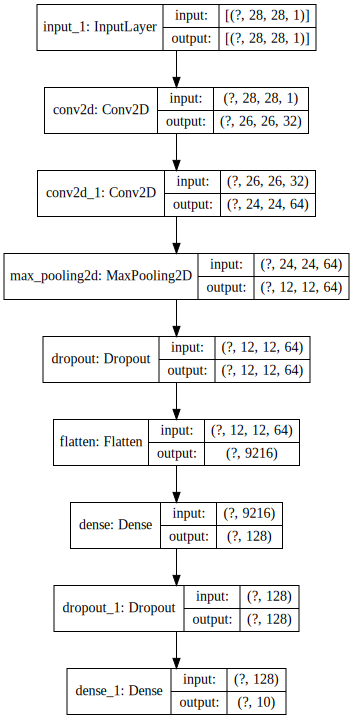

In [19]:
model_to_dot(model, show_shapes=True).write_pdf("img/ood_architecture-nn.pdf")
SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

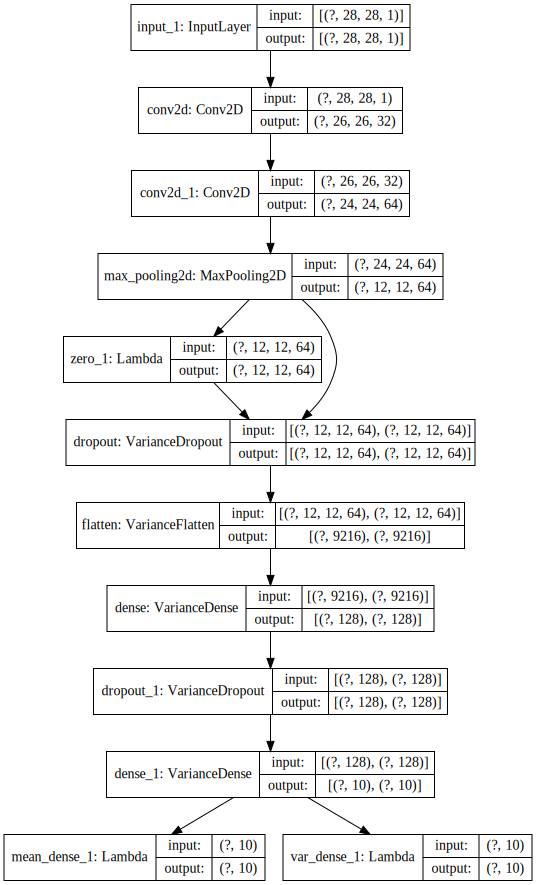

In [20]:
vmodel = nn2vpbnn(model)
model_to_dot(vmodel, show_shapes=True).write_pdf("img/ood_architecture-vpbnn.pdf")
SVG(model_to_dot(vmodel, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

In [21]:
def calc_auc(df, train_domain, test_domain):
    auc_dfs = []
    for pred_type in df['prediction_type'].unique():
        for bayes_model in df['bayes_model'].unique():
            for activation in df['last_activation'].unique():            
                cond_df = df[df['prediction_type'] == pred_type]
                cond_df = cond_df[cond_df['bayes_model'] == bayes_model]
                cond_df = cond_df[cond_df['last_activation'] == activation]
                fpr, tpr, thresholds = metrics.roc_curve(cond_df['test_domain'], -cond_df['y_uncertainty'], pos_label=train_domain)
                roc_auc = metrics.auc(fpr, tpr)
                auc_df = pd.DataFrame({'train_domain': [train_domain], 'test_domain': [test_domain], 'prediction_type': [pred_type], 'bayes_model': [bayes_model], 'last_activation': [activation], 'auc': [roc_auc]})
                auc_dfs.append(auc_df)
        
    auc_df = pd.concat(auc_dfs, ignore_index=True)
    auc_df['seed'] = df['seed'].iloc[0]
        
    return auc_df

In [22]:
auc_dfs = []
for csv_filepath in sorted(glob.glob('score/*.csv')):
    score_df = pd.read_csv(csv_filepath)
    for train_domain in score_df['train_domain'].unique():
        other_domains = set(score_df['test_domain'].unique()) - set([train_domain])
        for other_domain in other_domains:
            cond = np.logical_and(score_df['train_domain'] == train_domain, np.logical_or(score_df['test_domain'] == train_domain, score_df['test_domain'] == other_domain))
            auc_df = calc_auc(score_df[cond], train_domain, other_domain)
            auc_dfs.append(auc_df)
    auc_df = pd.concat(auc_dfs, ignore_index=True)

In [23]:
pd.set_option("display.max_rows", None)

auc_mean_df = auc_df.groupby(['train_domain', 'test_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'auc': ['mean', 'std']})
auc_mean_df['auc_str'] = auc_mean_df.apply(lambda x: '{0:.3f}±{1:.3f}'.format(x['auc']['mean'], x['auc']['std']), axis=1)
auc_mean_df

auc  \
                                                                                     mean   
train_domain test_domain  prediction_type           bayes_model last_activation             
Fashion      EMNIST-MNIST Independent-mode_entropy  MNIST-CNN   sigmoid          0.857908   
                                                                softmax          0.894668   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.946646   
                                                                softmax          0.920411   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.759818   
                                                                softmax          0.781770   
                          Linear-mode_mean-std      MNIST-CNN   sigmoid          0.837277   
                                                                softmax          0.769045   
                          MC-mode_entropy           MNIST-CNN   sigmoid          0.846422   
                                                                softmax          0.885129   
                          MC-mode_mean-std          MNIST-CNN   sigmoid          0.930017   
                                                                softmax          0.929715   
                          Normal-mode_entropy       MNIST-CNN   sigmoid          0.759818   
                                                                softmax          0.781770   
                          Upper-mode_entropy        MNIST-CNN   sigmoid          0.876904   
                                                                softmax          0.961379   
                          Upper-mode_mean-std       MNIST-CNN   sigmoid          0.943476   
                                                                softmax          0.963806   
             Kannada      Independent-mode_entropy  MNIST-CNN   sigmoid          0.796906   
                                                                softmax          0.865106   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.915563   
                                                                softmax          0.900217   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.676143   
                                                                softmax          0.714963   
                          Linear-mode_mean-std      MNIST-CNN   sigmoid          0.768770   
                                                                softmax          0.728382   
                          MC-mode_entropy           MNIST-CNN   sigmoid          0.783799   
                                                                softmax          0.856975   
                          MC-mode_mean-std          MNIST-CNN   sigmoid          0.896566   
                                                                softmax          0.916477   
                          Normal-mode_entropy       MNIST-CNN   sigmoid          0.676143   
                                                                softmax          0.714963   
                          Upper-mode_entropy        MNIST-CNN   sigmoid          0.817755   
                                                                softmax          0.951625   
                          Upper-mode_mean-std       MNIST-CNN   sigmoid          0.917120   
                                                                softmax          0.957402   
             Kuzushiji    Independent-mode_entropy  MNIST-CNN   sigmoid          0.893120   
                                                                softmax          0.922119   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.980910   
                                                                softmax          0.948589   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.7691

In [24]:
accuracy_dfs = []
for csv_filepath in sorted(glob.glob('score/*.csv')):
    df = pd.read_csv(csv_filepath)
    df = df[df['train_domain'] == df['test_domain']]
    df['correct'] = df['y_test'] == df['y_pred']
    accuracy_df = df[['train_domain', 'prediction_type', 'bayes_model', 'last_activation', 'correct']].groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).mean().reset_index()
    accuracy_df = accuracy_df.rename(columns={'correct': 'accuracy'})
    accuracy_df['seed'] = df['seed'].iloc[0]
    accuracy_dfs.append(accuracy_df)
accuracy_df = pd.concat(accuracy_dfs, ignore_index=True)

In [25]:
accuracy_mean_df = accuracy_df.groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'accuracy': ['mean', 'std']})
accuracy_mean_df['accuracy_str'] = accuracy_mean_df.apply(lambda x: '{0:.3f}±{1:.3f}'.format(x['accuracy']['mean'], x['accuracy']['std']), axis=1)
accuracy_mean_df

accuracy  \
                                                                        mean   
train_domain prediction_type           bayes_model last_activation             
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.923357   
                                                   softmax          0.922997   
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.923357   
                                                   softmax          0.922997   
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.923277   
                                                   softmax          0.922880   
             Linear-mode_mean-std      MNIST-CNN   sigmoid          0.923277   
                                                   softmax          0.922880   
             MC-mode_entropy           MNIST-CNN   sigmoid          0.923093   
                                                   softmax          0.922797   
             MC-mode_mean-std          MNIST-CNN   sigmoid          0.923093   
                                                   softmax          0.922797   
             Normal-mode_entropy       MNIST-CNN   sigmoid          0.923277   
                                                   softmax          0.922880   
             Upper-mode_entropy        MNIST-CNN   sigmoid          0.922453   
                                                   softmax          0.921873   
             Upper-mode_mean-std       MNIST-CNN   sigmoid          0.922453   
                                                   softmax          0.921873   

                                                                              \
                                                                         std   
train_domain prediction_type           bayes_model last_activation             
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.002182   
                                                   softmax          0.002481   
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.002182   
                                                   softmax          0.002481   
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.002301   
                                                   softmax          0.002447   
             Linear-mode_mean-std      MNIST-CNN   sigmoid          0.002301   
                                                   softmax          0.002447   
             MC-mode_entropy           MNIST-CNN   sigmoid          0.002269   
                                                   softmax          0.002505   
             MC-mode_mean-std          MNIST-CNN   sigmoid          0.002269   
                                                   softmax          0.002505   
             Normal-mode_entropy       MNIST-CNN   sigmoid          0.002301   
                                                   softmax          0.002447   
             Upper-mode_entropy        MNIST-CNN   sigmoid          0.002175   
                                                   softmax          0.002343   
             Upper-mode_mean-std       MNIST-CNN   sigmoid          0.002175   
                                                   softmax          0.002343   

                                                                   accuracy_str  
                                                                                 
train_domain prediction_type           bayes_model last_activation               
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.923±0.002  
                                                   softmax          0.923±0.002  
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.923±0.002  
                                                   softmax          0.923±0.002  
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.923±0.002  
                                                  